In [1]:
import numpy as np
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np
from numpy import random
import torch.nn as nn
from modules import EDMPrecond
from diffusion import *

In [2]:
def edm_sampler(conditional_vector,
                model_path="models/edm_e300_bs16/ema_ckpt.pt", 
                length=1024, 
                ):
    device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
   #device = torch.device('cpu')
    model = EDMPrecond(img_resolution   = length,
                    img_channels    = 1,
                    label_dim       = len(conditional_vector),
                    use_fp16        = False,
                    sigma_min       = 0,
                    sigma_max       = float('inf'),
                    sigma_data      = 0.5,
                    model_type      = 'UNet_conditional',
                   device=device
                    ).to(device)
    
    ckpt = torch.load(model_path,
                  map_location=device,
                  weights_only=True
                  )
    model.load_state_dict(ckpt)

    sampler = EdmSampler(net=model, num_steps=100)
    
    model.eval()
    with torch.no_grad():
        pred = sampler.sample(
                    length=length,
                    device=device,
                    class_labels=conditional_vector.to(device),
                    n_samples=1
                )
    return pred.cpu().numpy().flatten()
    

def loss_function(generated_intensities, target_intensities):
    return euclidean(generated_intensities, target_intensities)
    

def objective(conditional_vector, target_intensities):
    """
    The optimization objective function.
    """
    conditional_tensor = torch.tensor(conditional_vector, dtype=torch.float32)
    
    generated_intensities = edm_sampler(conditional_tensor)
    
    return loss_function(generated_intensities, target_intensities)


# Define the bounds of the conditional vector
param_space = [Real(0, 1) for _ in range(3)]


def optimize_parameters(target_intensities, n_calls=10):
    """
    Runs Bayesian optimization to find the best conditional vector that generates intensities
    similar to the target_intensities.
    """

    # Wrap objective function to include target_intensities
    def objective_wrapped(conditional_vector):
        return objective(conditional_vector, target_intensities)

    res = gp_minimize(objective_wrapped, param_space, n_calls=n_calls, random_state=42)

    best_params = res.x
    best_loss = res.fun
    return best_params, best_loss

In [3]:
csv_path = "../data/test_data_1024_[-1,1].csv"
df = pd.read_csv(csv_path)
target_intensities = np.array(eval(df["intensities"].iloc[0]))
target_cond_vector = np.array(eval(df["cond_vector"].iloc[0]))
wavelengths = np.load('../data/wavelengths.npy')

In [10]:
best_params, best_loss = optimize_parameters(target_intensities, n_calls=50)

print("Optimal Parameters:", best_params)
print("Best Loss:", best_loss)

Optimal Parameters: [0.2373791178372705, 0.0, 0.0]
Best Loss: 0.23421502138244682


In [8]:
def plot_results_bayesian_optimalization(best_params, target_cond_vector, target_intensities, wavelengths):
    """
    Generates predicted intensities using the best parameters, calculates MSE, and plots the results.
    
    Parameters:
        best_params (list or np.array): The optimal parameters from Bayesian optimization.
        target_intensities (np.array): The true intensity values to compare against.
        wavelengths (np.array): The wavelength values corresponding to the intensities.
    """
    best_params_tensor = torch.tensor(best_params, dtype=torch.float32)

    predicted_intensities = edm_sampler(best_params_tensor)

    mse = np.mean((target_intensities - predicted_intensities) ** 2)

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(wavelengths, target_intensities, label='True', color='tab:blue')
    ax.plot(wavelengths, predicted_intensities, label='Predicted', color='tab:orange')

    cond_str = ", ".join([f"{v:.3f}" for v in best_params])
    ax.set_title(f"Comparison of Actual and Predicted Intensities")

    ax.set_xlabel("Wavelengths")
    ax.set_ylabel("Intensity")
    ax.grid(True)
    ax.legend()
    plt.show()

    print("Found Optimal Parameters:", best_params)
    print("Real Parameters:", target_cond_vector)
    print("Best Loss (MSE):", mse)


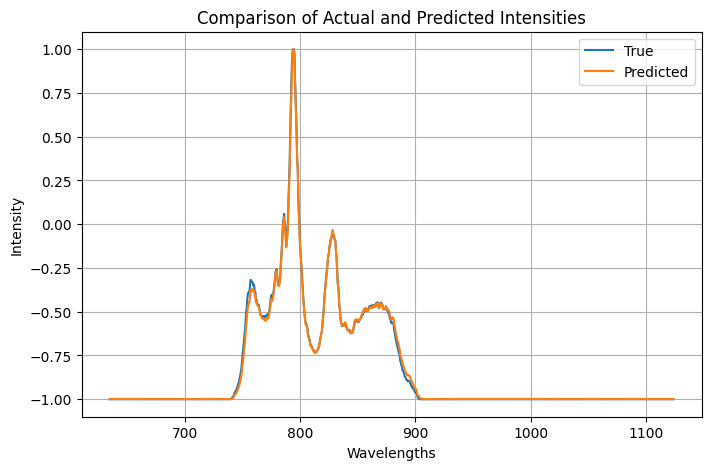

Found Optimal Parameters: [0.2373791178372705, 0.0, 0.0]
Real Parameters: [0.3163244  0.33911471 0.        ]
Best Loss (MSE): 0.00018704457185088103


In [11]:
plot_results_bayesian_optimalization(best_params, target_cond_vector, target_intensities, wavelengths)